---
# 
---

In this notebook

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import joblib

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

### Define files

In [4]:
#data_dir = '../data/'
data_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\data\\'
model_dir = 'C:\\Users\\jocl0\\ABF\\Final_Project-main\\model\\'

#ghg = 'GreenHouse_Gases/processed/'
ghg = 'GreenHouse_Gases\\processed\\'

frequency = 'DLY'

climate_file = 'ECCC\\processed\\daily\\daily_processed.csv'
#climate_file = 'ECCC/processed/daily/daily_processed.csv'
#climate_file = 'ECCC/processed/monthly/monthly_processed.csv'

population_file = 'Population\\processed\\Montreal.csv'
#population_file = 'Population/processed/Montreal.csv'

co2_file = 'co2_1850-2099_SSP2_45.csv'
ch4_file = 'ch4_1850-2099_SSP2_45.csv'

scenario = 'SSP2-45'

### Define variables

**Daily**

In [7]:
Tmax = 'Max Temp (°C)'
Tmin =  'Min Temp (°C)' 
Tmean = 'Mean Temp (°C)'

cols = ['Max Temp (°C)', 'Max Temp Flag', 'Min Temp (°C)', 'Min Temp Flag',
       'Mean Temp (°C)', 'Mean Temp Flag', 'Heat Deg Days (°C)',
       'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag',
       'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)',
       'Total Snow Flag', 'Total Precip (mm)', 'Total Precip Flag',
       'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)',
       'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)',
       'Spd of Max Gust Flag']

**Monthly**

### Read data files

In [10]:
co2_df = pd.read_csv(os.path.join(data_dir, ghg, co2_file), index_col=0, parse_dates=True)
co2_df.drop(columns = 'Data Source', inplace=True)
co2_df

,CO2
Year,
1850-01-01,285.200000
1851-01-01,285.100000
1852-01-01,285.000000
1853-01-01,285.000000
1854-01-01,284.900000
...,...
2095-01-01,600.885986
2096-01-01,601.365967
2097-01-01,601.796997


In [11]:
ch4_df = pd.read_csv(os.path.join(data_dir, ghg, ch4_file), index_col=0, parse_dates=True)
ch4_df

,CH4
Year,
1850-01-01,791.600000
1851-01-01,792.859068
1852-01-01,794.156502
1853-01-01,795.493289
1854-01-01,796.859405
...,...
2095-01-01,1698.879883
2096-01-01,1695.429810
2097-01-01,1692.139893


In [12]:
pop_df = pd.read_csv(os.path.join(data_dir, population_file), index_col=0, parse_dates=True)
pop_df

,Population
1801-01-01,9.000000e+03
1802-01-01,9.389547e+03
1803-01-01,9.788026e+03
1804-01-01,1.019544e+04
1805-01-01,1.061293e+04
...,...
2095-01-01,2.258385e+06
2096-01-01,2.249969e+06
2097-01-01,2.240726e+06
2098-01-01,2.230707e+06


In [13]:
wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)
wx_df

C:\Users\jocl0\AppData\Local\Temp\ipykernel_65644\1851272773.py:1: DtypeWarning: Columns (5,11,13,15,17,19,27,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  wx_df = pd.read_csv(os.path.join(data_dir, climate_file), index_col=0, parse_dates=True)


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,0.0,NaN,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,NaN,NaN,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,NaN,NaN,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,NaN,NaN,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN


In [14]:
wx_df['tmin_lag1'] = wx_df[Tmin].shift(1)
wx_df['tmax_lag1'] = wx_df[Tmax].shift(1)
wx_df

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1891-10-22,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,22,NaN,5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891-10-23,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,23,NaN,3.9,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.7,5.6
1891-10-24,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,24,NaN,5.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.1,3.9
1891-10-25,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,25,NaN,3.3,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.2,5.0
1891-10-26,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1891,10,26,NaN,10.6,...,4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.3,3.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-23,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,23,NaN,-1.6,...,0.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,-7.5,10.7
2025-03-24,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,24,NaN,3.9,...,6.7,NaN,9.0,NaN,NaN,NaN,NaN,NaN,-9.8,-1.6
2025-03-25,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2025,3,25,NaN,4.5,...,1.1,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-4.6,3.9


### Remove incomplete start and end year of climate dataset

In [16]:
tmp = wx_df.groupby(['Year']).count()

tmp[tmp['Station'] < 365]

,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Month,Day,Data Quality,Max Temp (°C),Max Temp Flag,...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Year,,,,,,,,,,,,,,,,,,,,,
1891,71,71,71,71,71,71,71,0,71,0,...,71,10,0,0,0,0,0,0,70,70
2025,86,86,86,86,86,86,86,0,86,0,...,85,1,86,0,27,0,27,0,86,86


In [17]:
start_wx = wx_df.index.min()
end_wx = wx_df.index.max()
print(type(start_wx), end_wx)

for year in [start_wx, end_wx] :

    nbr_days_year = 366 if pd.Period(year, freq='Y').is_leap_year else 365

    yr = int(year.strftime('%Y'))
    nbr_obs_year = tmp[tmp.index == yr]['Station'].values[0]

    print('*',yr, nbr_obs_year, '*')
    
    if nbr_obs_year != nbr_days_year :
        print(f'Not full year. Removing partial {yr} from dataframe')
        wx_df = wx_df[wx_df['Year'] != yr]

        start_wx = wx_df.index.min()
        end_wx = wx_df.index.max()
    else :
        print(f'Full year. Not removing {yr} from obs dataframe.')
    
wx_df

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2025-03-27 00:00:00
* 1891 71 *
Not full year. Removing partial 1891 from dataframe
* 2025 86 *
Not full year. Removing partial 2025 from dataframe


,Station,Longitude (x),Latitude (y),Station Name,Climate ID,Year,Month,Day,Data Quality,Max Temp (°C),...,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag,tmin_lag1,tmax_lag1
Date/Time,,,,,,,,,,,,,,,,,,,,,
1892-01-01,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,1,NaN,-5.6,...,0.0,T,NaN,NaN,NaN,NaN,NaN,NaN,-18.3,-10.6
1892-01-02,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,2,NaN,6.7,...,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.7,-5.6
1892-01-03,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,3,NaN,2.2,...,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.1,6.7
1892-01-04,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,4,NaN,-7.2,...,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.8,2.2
1892-01-05,Montreal (McTavish/McGill),-73.58,45.5,MONTREAL MCGILL,7025280,1892,1,5,NaN,-12.2,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-15.0,-7.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,27,NaN,-6.1,...,0.0,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.7,-7.9
2024-12-28,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,28,NaN,-1.7,...,0.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-13.2,-6.1
2024-12-29,Montreal (McTavish/McGill),-73.58,45.5,MCTAVISH,7024745,2024,12,29,NaN,7.6,...,5.2,NaN,11.0,NaN,NaN,NaN,NaN,NaN,-9.6,-1.7


### Put the GreenHouse Gases dataframe and population dataframe on the same frequency as the climate data

In [19]:
if frequency == 'DLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="D")
    print(new_range)
    
    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('D').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('D').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('D').interpolate()
    
elif frequency == 'MLY':
    new_range = pd.date_range(start = start_wx, end = end_wx, freq="ME")
    print(new_range)

    co2_df = co2_df.reindex(new_range)
    co2_df = co2_df.resample('ME').interpolate()

    ch4_df = ch4_df.reindex(new_range)
    ch4_df = ch4_df.resample('ME').interpolate()

    pop_df = pop_df.reindex(new_range)
    pop_df = pop_df.resample('ME').interpolate()
else :
    print('Frequency is NOT monthly or daily')

DatetimeIndex(['1892-01-01', '1892-01-02', '1892-01-03', '1892-01-04',
               '1892-01-05', '1892-01-06', '1892-01-07', '1892-01-08',
               '1892-01-09', '1892-01-10',
               ...
               '2024-12-22', '2024-12-23', '2024-12-24', '2024-12-25',
               '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', length=48578, freq='D')


In [20]:
co2_df

,CO2
1892-01-01,294.800000
1892-01-02,294.799727
1892-01-03,294.799454
1892-01-04,294.799180
1892-01-05,294.798907
...,...
2024-12-27,424.610000
2024-12-28,424.610000
2024-12-29,424.610000
2024-12-30,424.610000


In [21]:
ch4_df

,CH4
1892-01-01,859.921329
1892-01-02,859.925885
1892-01-03,859.930442
1892-01-04,859.934998
1892-01-05,859.939554
...,...
2024-12-27,1934.802141
2024-12-28,1934.802141
2024-12-29,1934.802141
2024-12-30,1934.802141


In [22]:
pop_df

,Population
1892-01-01,2.609199e+05
1892-01-02,2.609370e+05
1892-01-03,2.609540e+05
1892-01-04,2.609711e+05
1892-01-05,2.609881e+05
...,...
2024-12-27,2.200807e+06
2024-12-28,2.200807e+06
2024-12-29,2.200807e+06
2024-12-30,2.200807e+06


### Put all the data into a single dataframe

In [24]:
full_df = pd.concat([co2_df, ch4_df, pop_df, wx_df[[Tmax,Tmin]]], axis=1)
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C)
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7
...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3


In [25]:
# Add lagged temperature features
full_df['tmin_lag1'] = wx_df['tmin_lag1']
full_df['tmax_lag1'] = wx_df['tmax_lag1']
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2
...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6


In [26]:
full_df['dayofyear'] = full_df.index.dayofyear
#full_df['sin_doy'] = np.sin(2 * np.pi * full_df['dayofyear'] / 365.)
#full_df['cos_doy'] = np.cos(2 * np.pi * full_df['dayofyear'] / 365.)
#full_df.drop(columns=['dayofyear'], inplace=True)
full_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6,1
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6,2
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7,3
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2,4
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2,5
...,...,...,...,...,...,...,...,...
2024-12-27,424.610000,1934.802141,2.200807e+06,-6.1,-13.2,-13.7,-7.9,362
2024-12-28,424.610000,1934.802141,2.200807e+06,-1.7,-9.6,-13.2,-6.1,363
2024-12-29,424.610000,1934.802141,2.200807e+06,7.6,-2.6,-9.6,-1.7,364
2024-12-30,424.610000,1934.802141,2.200807e+06,10.6,3.3,-2.6,7.6,365


### Separate Train/Test/Validate dataset

In [28]:
cut_year_test = 2021
cut_year_val = 2023

cut_test = pd.to_datetime(cut_year_test, format='%Y')
cut_val = pd.to_datetime(cut_year_val, format='%Y')

train_df = full_df[full_df.index < cut_test]
test_df = full_df[(full_df.index >= cut_test) & (full_df.index < cut_val)]
val_df = full_df[full_df.index >= cut_val]

In [29]:
test_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear
2021-01-01,416.410000,1894.800000,1.762949e+06,-0.2,-5.1,-6.9,3.7,1
2021-01-02,416.415808,1894.844164,1.763361e+06,-0.6,-5.3,-5.1,-0.2,2
2021-01-03,416.421616,1894.888329,1.763773e+06,-0.6,-3.5,-5.3,-0.6,3
2021-01-04,416.427425,1894.932493,1.764185e+06,-1.1,-3.4,-3.5,-0.6,4
2021-01-05,416.433233,1894.976658,1.764598e+06,-2.5,-3.6,-3.4,-1.1,5
...,...,...,...,...,...,...,...,...
2022-12-27,421.045068,1921.552329,2.100692e+06,-4.2,-8.7,-8.9,-3.3,361
2022-12-28,421.052055,1921.581863,2.101212e+06,0.2,-4.2,-8.7,-4.2,362
2022-12-29,421.059041,1921.611397,2.101732e+06,6.4,-0.6,-4.2,0.2,363
2022-12-30,421.066027,1921.640932,2.102253e+06,9.8,5.1,-0.6,6.4,364


In [30]:
train_df

,CO2,CH4,Population,Max Temp (°C),Min Temp (°C),tmin_lag1,tmax_lag1,dayofyear
1892-01-01,294.800000,859.921329,2.609199e+05,-5.6,-11.7,-18.3,-10.6,1
1892-01-02,294.799727,859.925885,2.609370e+05,6.7,-6.1,-11.7,-5.6,2
1892-01-03,294.799454,859.930442,2.609540e+05,2.2,-7.8,-6.1,6.7,3
1892-01-04,294.799180,859.934998,2.609711e+05,-7.2,-15.0,-7.8,2.2,4
1892-01-05,294.798907,859.939554,2.609881e+05,-12.2,-16.7,-15.0,-7.2,5
...,...,...,...,...,...,...,...,...
2020-12-27,416.379945,1894.580328,1.761731e+06,-2.7,-8.7,-8.1,-0.3,362
2020-12-28,416.385956,1894.624262,1.761975e+06,4.7,-2.7,-8.7,-2.7,363
2020-12-29,416.391967,1894.668197,1.762218e+06,-2.2,-8.8,-2.7,4.7,364
2020-12-30,416.397978,1894.712131,1.762462e+06,0.8,-7.3,-8.8,-2.2,365


### Separate RNN input and output data

In [32]:
cols_in = ['CH4', 'CO2', 'Population', 'tmin_lag1', 'tmax_lag1', 'dayofyear'] #, 'sin_doy', 'cos_doy'] #'dayofyear']
cols_out = [Tmax, Tmin]

X_train = train_df[cols_in]
X_test = test_df[cols_in]

Y_train = train_df[cols_out]
Y_test = test_df[cols_out]

### Scale the dataset

In [34]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled_train = scaler_x.fit_transform(X_train)
X_scaled_test = scaler_x.transform(X_test)

Y_scaled_train = scaler_y.fit_transform(Y_train)
Y_scaled_test = scaler_y.transform(Y_test)

### Load RNN model

In [45]:
rnn = load_model(os.path.join(model_dir, 'rnn_new_365_patience10_kernel512.keras'))

In [47]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1062912   
                                                                 
 dense (Dense)               (None, 2)                 1026      
                                                                 
Total params: 1,063,938
Trainable params: 1,063,938
Non-trainable params: 0
_________________________________________________________________


### Evaluate the model on the testing dataset

In [51]:
rnn_prediction_test = []
window_size = 3 * 31
#window_size = len(X_scaled_train) #n_input
print(window_size)
n_steps = 365

n_features = X_scaled_train.shape[1]

##current_data = X_scaled_train[-(window_size):]  # (window_size - 1, features)
#first_test_step = X_scaled_test[0].reshape(1, -1)   # (1, features)
#current_data = np.vstack([current_data, first_test_step])  # (window_size, features)
##current_data = current_data.reshape(1, window_size, n_features)  # Add batch dim

#current_data = X_scaled_test[-len_:].reshape((1, steps, n_features))

#len_ = X_scaled_test.shape[0]

current_data = X_scaled_train[-(window_size):] 
current_data = current_data.reshape(1, window_size, n_features)

# next_input_step = X_scaled_test[0].copy()
# next_input_step = next_input_step.reshape(1, 1, n_features)
# current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)


##train_tail = X_scaled_train[-(window_size - 1):]  # Shape: (window_size - 1, n_features)

##first_test_step = X_scaled_test[0].reshape(1, n_features)  # Shape: (1, n_features)

##current_data = np.vstack([train_tail, first_test_step])  # Shape: (window_size, n_features)
##current_data = current_data.reshape(1, window_size, n_features)

for i in range(n_steps): 
    
    # This is our prediction for 1 timestep into the future
    current_prediction = rnn.predict(current_data)[0]
    
    # Append it to our list of prediction
    rnn_prediction_test.append(current_prediction)

    #next_input_step = X_scaled_test[i].reshape(1, 1, n_features)

    #next_input_step = X_scaled_test[i+1].copy()  # shape: (n_features,)
    next_input_step = X_scaled_test[i].copy()  # shape: (n_features,)
    next_input_step[-2:] = current_prediction  # replace tmin, tmax with prediction
    next_input_step = next_input_step.reshape(1, 1, n_features)
    
    #current_data = X_scaled_train[-(window_size - 1 - i):]  # (window_size - 1, features)
    #print(len(current_data))
    ##X_scaled_test = X_scaled_test[1:]
    #first_test_step = X_scaled_test[0].reshape(1, -1)   # (1, features)
    ##first_test_step = X_scaled_test[0].reshape(1, 1, n_features) 
    #print(len(first_test_step)) 
    #current_data = np.vstack([current_data, first_test_step])  # (window_size, features)
    #current_data = current_data.reshape(1, window_size, n_features)  # Add batch dim
    
    current_data = np.append(current_data[:,1:,:], next_input_step, axis=1)

rnn_prediction_test

93
1/1 [==============================] - 0s 49ms/step


[array([0.426951  , 0.44080612], dtype=float32),
 array([0.42479065, 0.43730026], dtype=float32),
 array([0.42326686, 0.43855444], dtype=float32),
 array([0.42115462, 0.43790665], dtype=float32),
 array([0.42102683, 0.4400403 ], dtype=float32),
 array([0.42077377, 0.44101337], dtype=float32),
 array([0.42053214, 0.44127807], dtype=float32),
 array([0.41914168, 0.43864974], dtype=float32),
 array([0.4179517 , 0.43584117], dtype=float32),
 array([0.41521958, 0.429744  ], dtype=float32),
 array([0.41616943, 0.43015033], dtype=float32),
 array([0.4154472 , 0.42721188], dtype=float32),
 array([0.41867703, 0.4316796 ], dtype=float32),
 array([0.4256298 , 0.44295123], dtype=float32),
 array([0.43104714, 0.45126647], dtype=float32),
 array([0.43708253, 0.4606459 ], dtype=float32),
 array([0.43970588, 0.46339127], dtype=float32),
 array([0.44431457, 0.46953163], dtype=float32),
 array([0.4454523 , 0.46883768], dtype=float32),
 array([0.4431062 , 0.46141687], dtype=float32),
 array([0.44179422, 

### Inversing prediction

In [53]:
inversed_preds_test = scaler_y.inverse_transform(rnn_prediction_test)

cols_out_new = (pd.Series(cols_out) + 'model').tolist()

pred_test_df = pd.DataFrame(inversed_preds_test, columns=cols_out_new)

pred_test_df.index = test_df.iloc[:n_steps].index

full_pred_test_df = pd.concat([test_df.iloc[:n_steps], pred_test_df], axis=1)

full_pred_test_df.columns

Index(['CO2', 'CH4', 'Population', 'Max Temp (°C)', 'Min Temp (°C)',
       'tmin_lag1', 'tmax_lag1', 'dayofyear', 'Max Temp (°C)model',
       'Min Temp (°C)model'],
      dtype='object')

### Evaluating model's prediction accuracy

In [55]:
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmax],full_pred_test_df[cols_out_new[0]]))}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(full_pred_test_df[Tmin],full_pred_test_df[cols_out_new[1]]))}")

Test RMSE: 8.422735181289294
Test RMSE: 6.582716081186301


<Axes: >

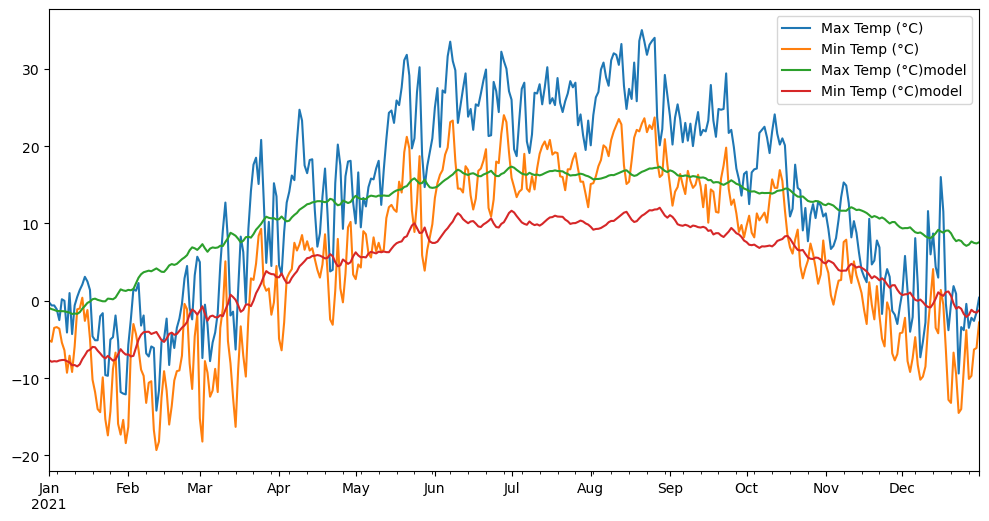

In [57]:
tmp = full_pred_test_df.drop(columns=['CO2', 'CH4', 'Population', 'tmin_lag1',	'tmax_lag1', 'dayofyear'])
tmp.plot(figsize=(12,6))

In [ ]:
full_pred_test_df.drop(columns=cols_in).iloc[-31:].plot(figsize=(12,6))